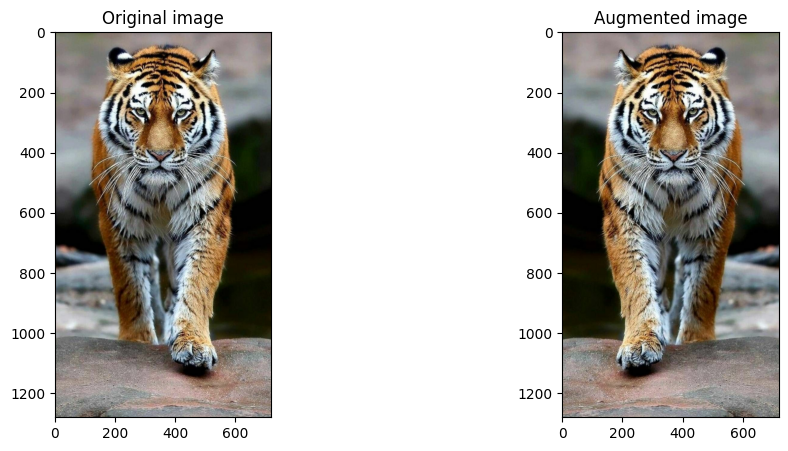

In [27]:
import urllib
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_datasets as tfds
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (12, 5)
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_path = "/home/ayush/Downloads/tiger.jpg"
PIL.Image.open(image_path)
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

flipped = tf.image.flip_left_right(image)
visualize(image, flipped)


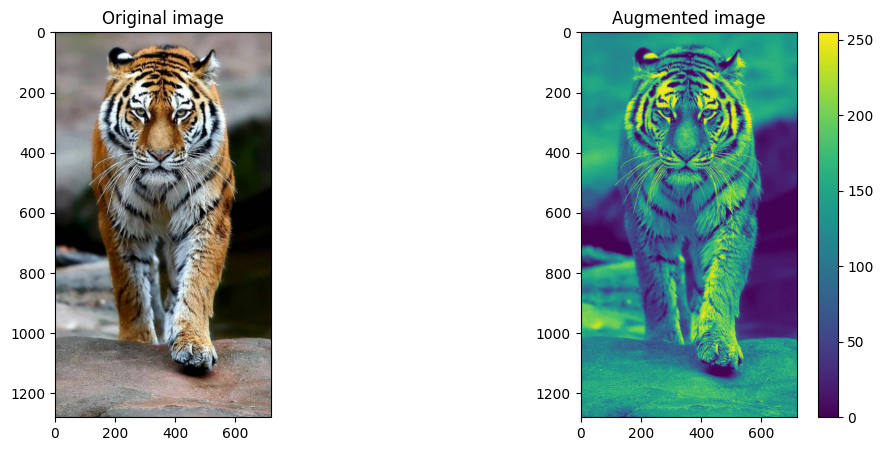

In [15]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

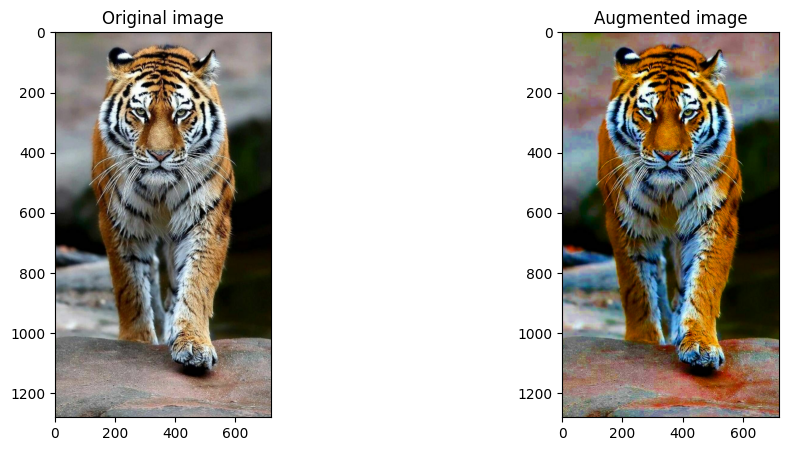

In [16]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

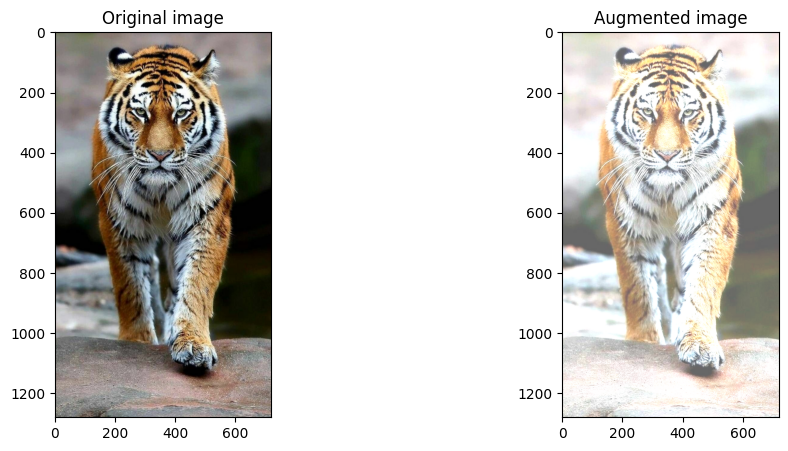

In [17]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

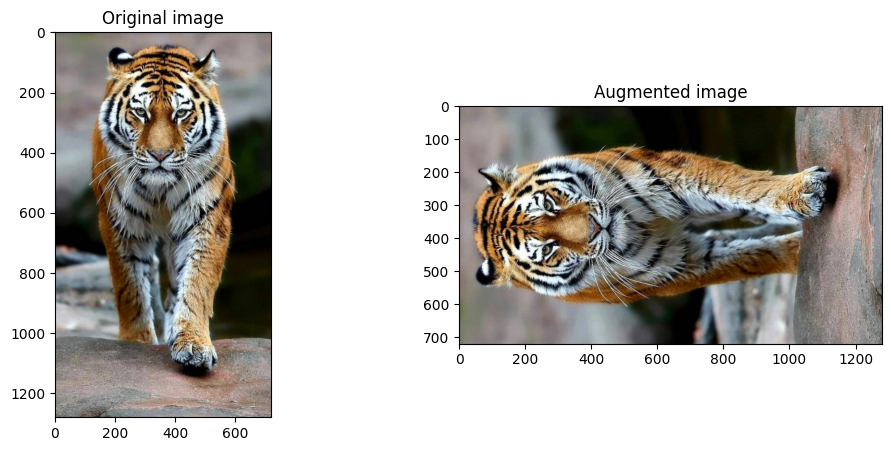

In [18]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

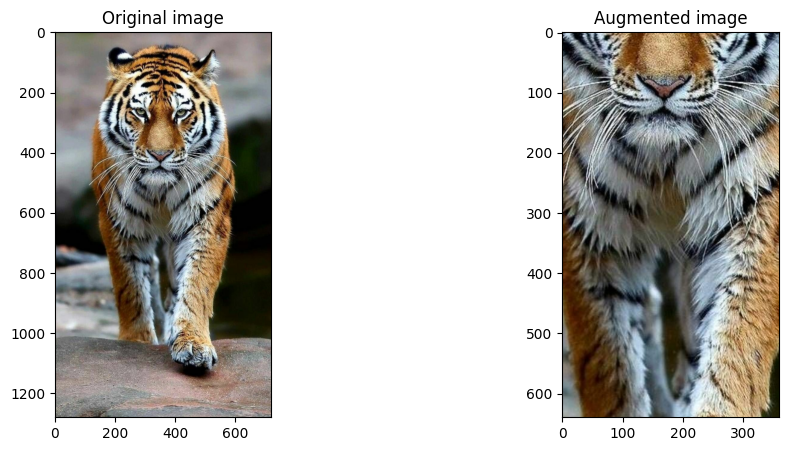

In [19]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

In [20]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

In [21]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) 
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) 
  image = tf.image.random_crop(image, size=[28, 28, 1]) 
  image = tf.image.random_brightness(image, max_delta=0.5)

  return image,label
BATCH_SIZE = 64

NUM_EXAMPLES = 2048
augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

non_augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [22]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [24]:
model_without_aug = make_model()
no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)                     

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5905 - loss: 1.3381 - val_accuracy: 0.8909 - val_loss: 0.3559
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9466 - loss: 0.1943 - val_accuracy: 0.8952 - val_loss: 0.3477
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9629 - loss: 0.1040 - val_accuracy: 0.9103 - val_loss: 0.3386
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9842 - loss: 0.0532 - val_accuracy: 0.9224 - val_loss: 0.3062
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9896 - loss: 0.0274 - val_accuracy: 0.9295 - val_loss: 0.3015
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9906 - loss: 0.0421 - val_accuracy: 0.9317 - val_loss: 0.3091
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9979 - loss: 0.0052 - val_accuracy: 0.9316 - val_loss: 0.3363
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.

In [28]:
model_with_aug = make_model()
aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.1859 - loss: 3.1689 - val_accuracy: 0.7001 - val_loss: 1.2245
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.4991 - loss: 1.5113 - val_accuracy: 0.8142 - val_loss: 0.6685
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.6512 - loss: 1.0085 - val_accuracy: 0.8417 - val_loss: 0.5549
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7118 - loss: 0.8770 - val_accuracy: 0.8750 - val_loss: 0.4169
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7886 - loss: 0.6918 - val_accuracy: 0.8819 - val_loss: 0.3842
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7988 - loss: 0.6399 - val_accuracy: 0.8541 - val_loss: 0.4447
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.8160 - loss: 0.5890 - val_accuracy: 0.9010 - val_loss: 0.3126
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.8551 - loss: 0.4445 - val_accuracy: 0.

(0.75, 1.0)

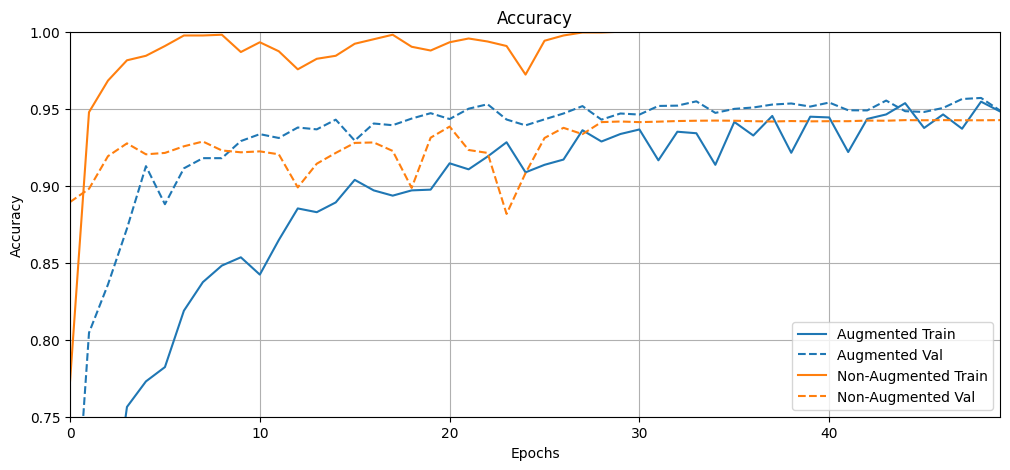

In [13]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])